# Action 高铁乘客数量预测

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from itertools import product 
import calendar
import datetime

In [2]:
data=pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [3]:
print(data)

          ID          Datetime  Count
0          0  25-08-2012 00:00      8
1          1  25-08-2012 01:00      2
2          2  25-08-2012 02:00      6
3          3  25-08-2012 03:00      2
4          4  25-08-2012 04:00      2
...      ...               ...    ...
18283  18283  25-09-2014 19:00    868
18284  18284  25-09-2014 20:00    732
18285  18285  25-09-2014 21:00    702
18286  18286  25-09-2014 22:00    580
18287  18287  25-09-2014 23:00    534

[18288 rows x 3 columns]


In [4]:
data['Date']=pd.to_datetime(data.Datetime,format='%d-%m-%Y %H:%M%S')
data=data.sort_values(by='Date',ascending=True)
df=data[['Date','Count']]
df.index=df.Date
data_day=df.resample('D').sum()
print(data_day)

            Count
Date             
2012-08-25     76
2012-08-26     88
2012-08-27     62
2012-08-28     58
2012-08-29     60
...           ...
2014-09-21   9102
2014-09-22  14116
2014-09-23  13304
2014-09-24  16856
2014-09-25  14152

[762 rows x 1 columns]


In [5]:
# 模型拟合
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2) #使用1阶差分
parameters = product(ps, qs,ds)
parameters_list = list(parameters)
sign=False
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data_day.Count,
                                order=(param[0], param[1], param[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    print(aic)
    if sign==False:
        best_aic=aic
        sign=True
    if (aic<best_aic):
        best_aic=aic
        best_model=model
# 输出最优模型
print('最优模型: ', best_model.summary())

14451.903203770986
12982.572915056333
13032.581596614473
13506.40971811703
14223.137943015574
12991.987263230463
12794.822799964524
13027.964535486384
13432.821764523593
13979.447445659789


d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12779.541716958713
12686.444672562517
12890.452509806324
13312.143777729141
13756.42936294977
12689.514587208409
12663.96687183195
12932.014283537297
13276.24940805
13660.690703193535
12666.709075618932
12561.142121922516
12757.377651408122
13164.86473286898
13575.37214526872
最优模型:                             Statespace Model Results                           
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -6274.571
Date:                Mon, 29 Mar 2021   AIC                          12561.142
Time:                        13:19:56   BIC                          12588.918
Sample:                    08-25-2012   HQIC                         12571.840
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

In [6]:
#计算需要预测的日期
future_month=7
last_year=data_day.index[-1].year
last_month=data_day.index[-1].month
last_day=data_day.index[-1].day
start_day=datetime.date(last_year,last_month,last_day)+datetime.timedelta(days=+1)
end_year=last_year
end_month=last_month+future_month
if (end_month>12):
    end_month=end_month-12
    end_year=end_year+1
end_day=calendar.monthrange(end_year,end_month)[1]
if (end_day>last_day):
    end_day=last_day
end_day=datetime.date(end_year,end_month,end_day)
start_day=start_day+datetime.timedelta(days=1)
date_list=[]
while start_day<=end_day:
    date_list.append(start_day)
    start_day=start_day+datetime.timedelta(days=1)

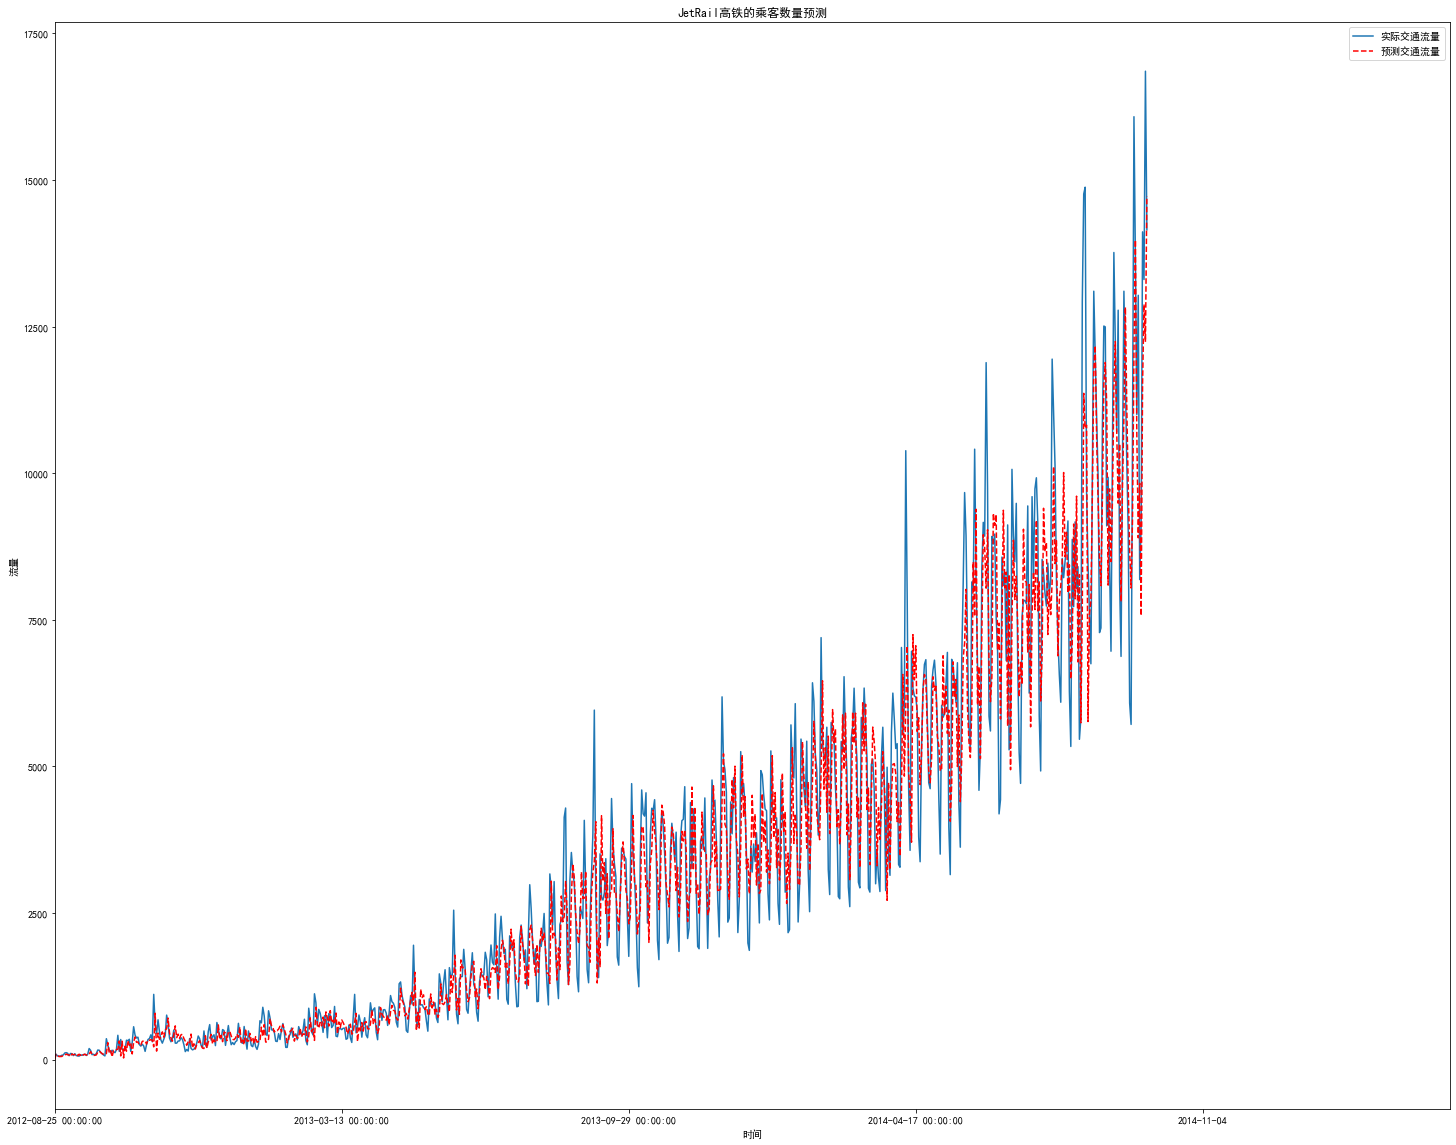

In [7]:
#数据预测
future = pd.DataFrame(index=date_list, columns= data_day.columns)
df_forecast = pd.concat([data_day, future])
df_forecast['forecast'] = best_model.get_prediction(start=0, end=len(df_forecast)).predicted_mean
plt.figure(figsize=(25,20))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
df_forecast.Count.plot(label='实际交通流量')
df_forecast.forecast.plot(color='r', ls='--', label='预测交通流量')
plt.legend()
plt.title('JetRail高铁的乘客数量预测')
plt.xlabel('时间')
plt.ylabel('流量')
plt.show()